In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ticktack
from jax import jit
import jax.numpy as jnp
from ticktack import fitting, resample
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq

plt.rcParams['figure.figsize'] = (8.0, 6.0)
#from helper import run_resample, load_IntCal20
import pandas as pd
import scipy.signal
import statistics

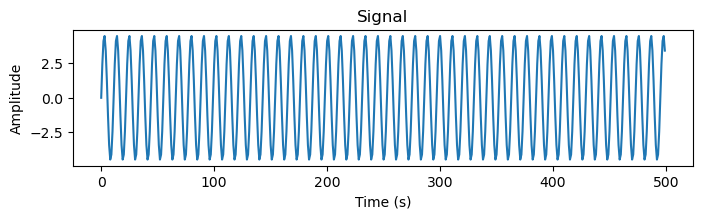

In [2]:
##THIS CODE IS FROM HERE: https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

t= np.arange(500)
period = 11.
SNR=4.5
y = SNR*np.sin(2*np.pi*t/period)
plt.subplot(3,1,1)
plt.plot(t, y)
plt.title('Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()

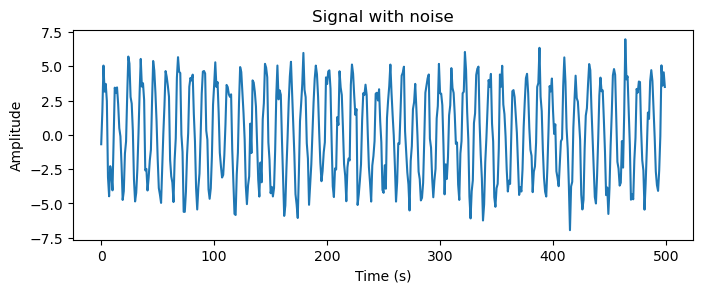

In [3]:
# Generate a sample of white noise
mean_noise = 0
noise = np.random.randn(len(t))
# Noise up the original signal
y_noise = y + noise

# Plot signal with noise
plt.subplot(2,1,1)
plt.plot(t, y_noise)
plt.title('Signal with noise')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()

<ErrorbarContainer object of 3 artists>

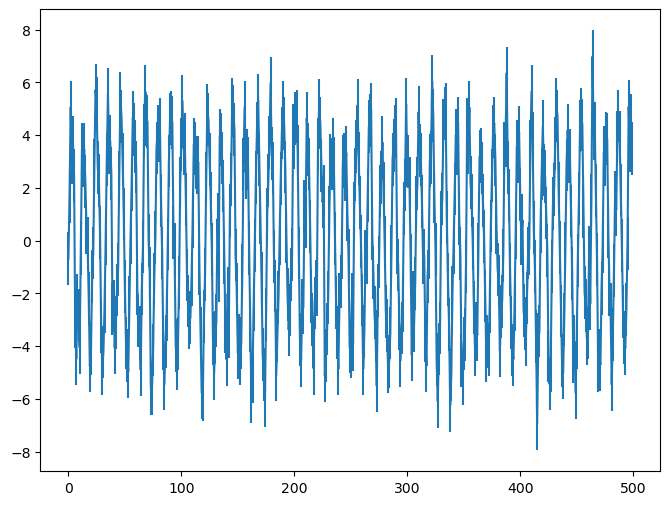

In [4]:
new_signal=y_noise
errors=np.ones(len(noise))
load_data={'year':t,
          'd14c':new_signal,
          'sig_d14c':errors}
data=pd.DataFrame(load_data)
plt.errorbar(data.year, data.d14c, yerr=data.sig_d14c, linestyle='-')

In [5]:
resampler = resample.Resampler()
resampler.load_data(data.year, data.d14c, data.sig_d14c)
resampler.annual = np.arange(np.ceil(resampler.start), np.floor(resampler.end + 1))
new_signal = resampler.signal_resample(size=128)
f = interp1d(resampler.x, resampler.y, kind="cubic")
interpolation = f(resampler.annual)
sig = resampler.bandpass_super_gaussian(interpolation, l=1./9.677, sz=0.05, order=30)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


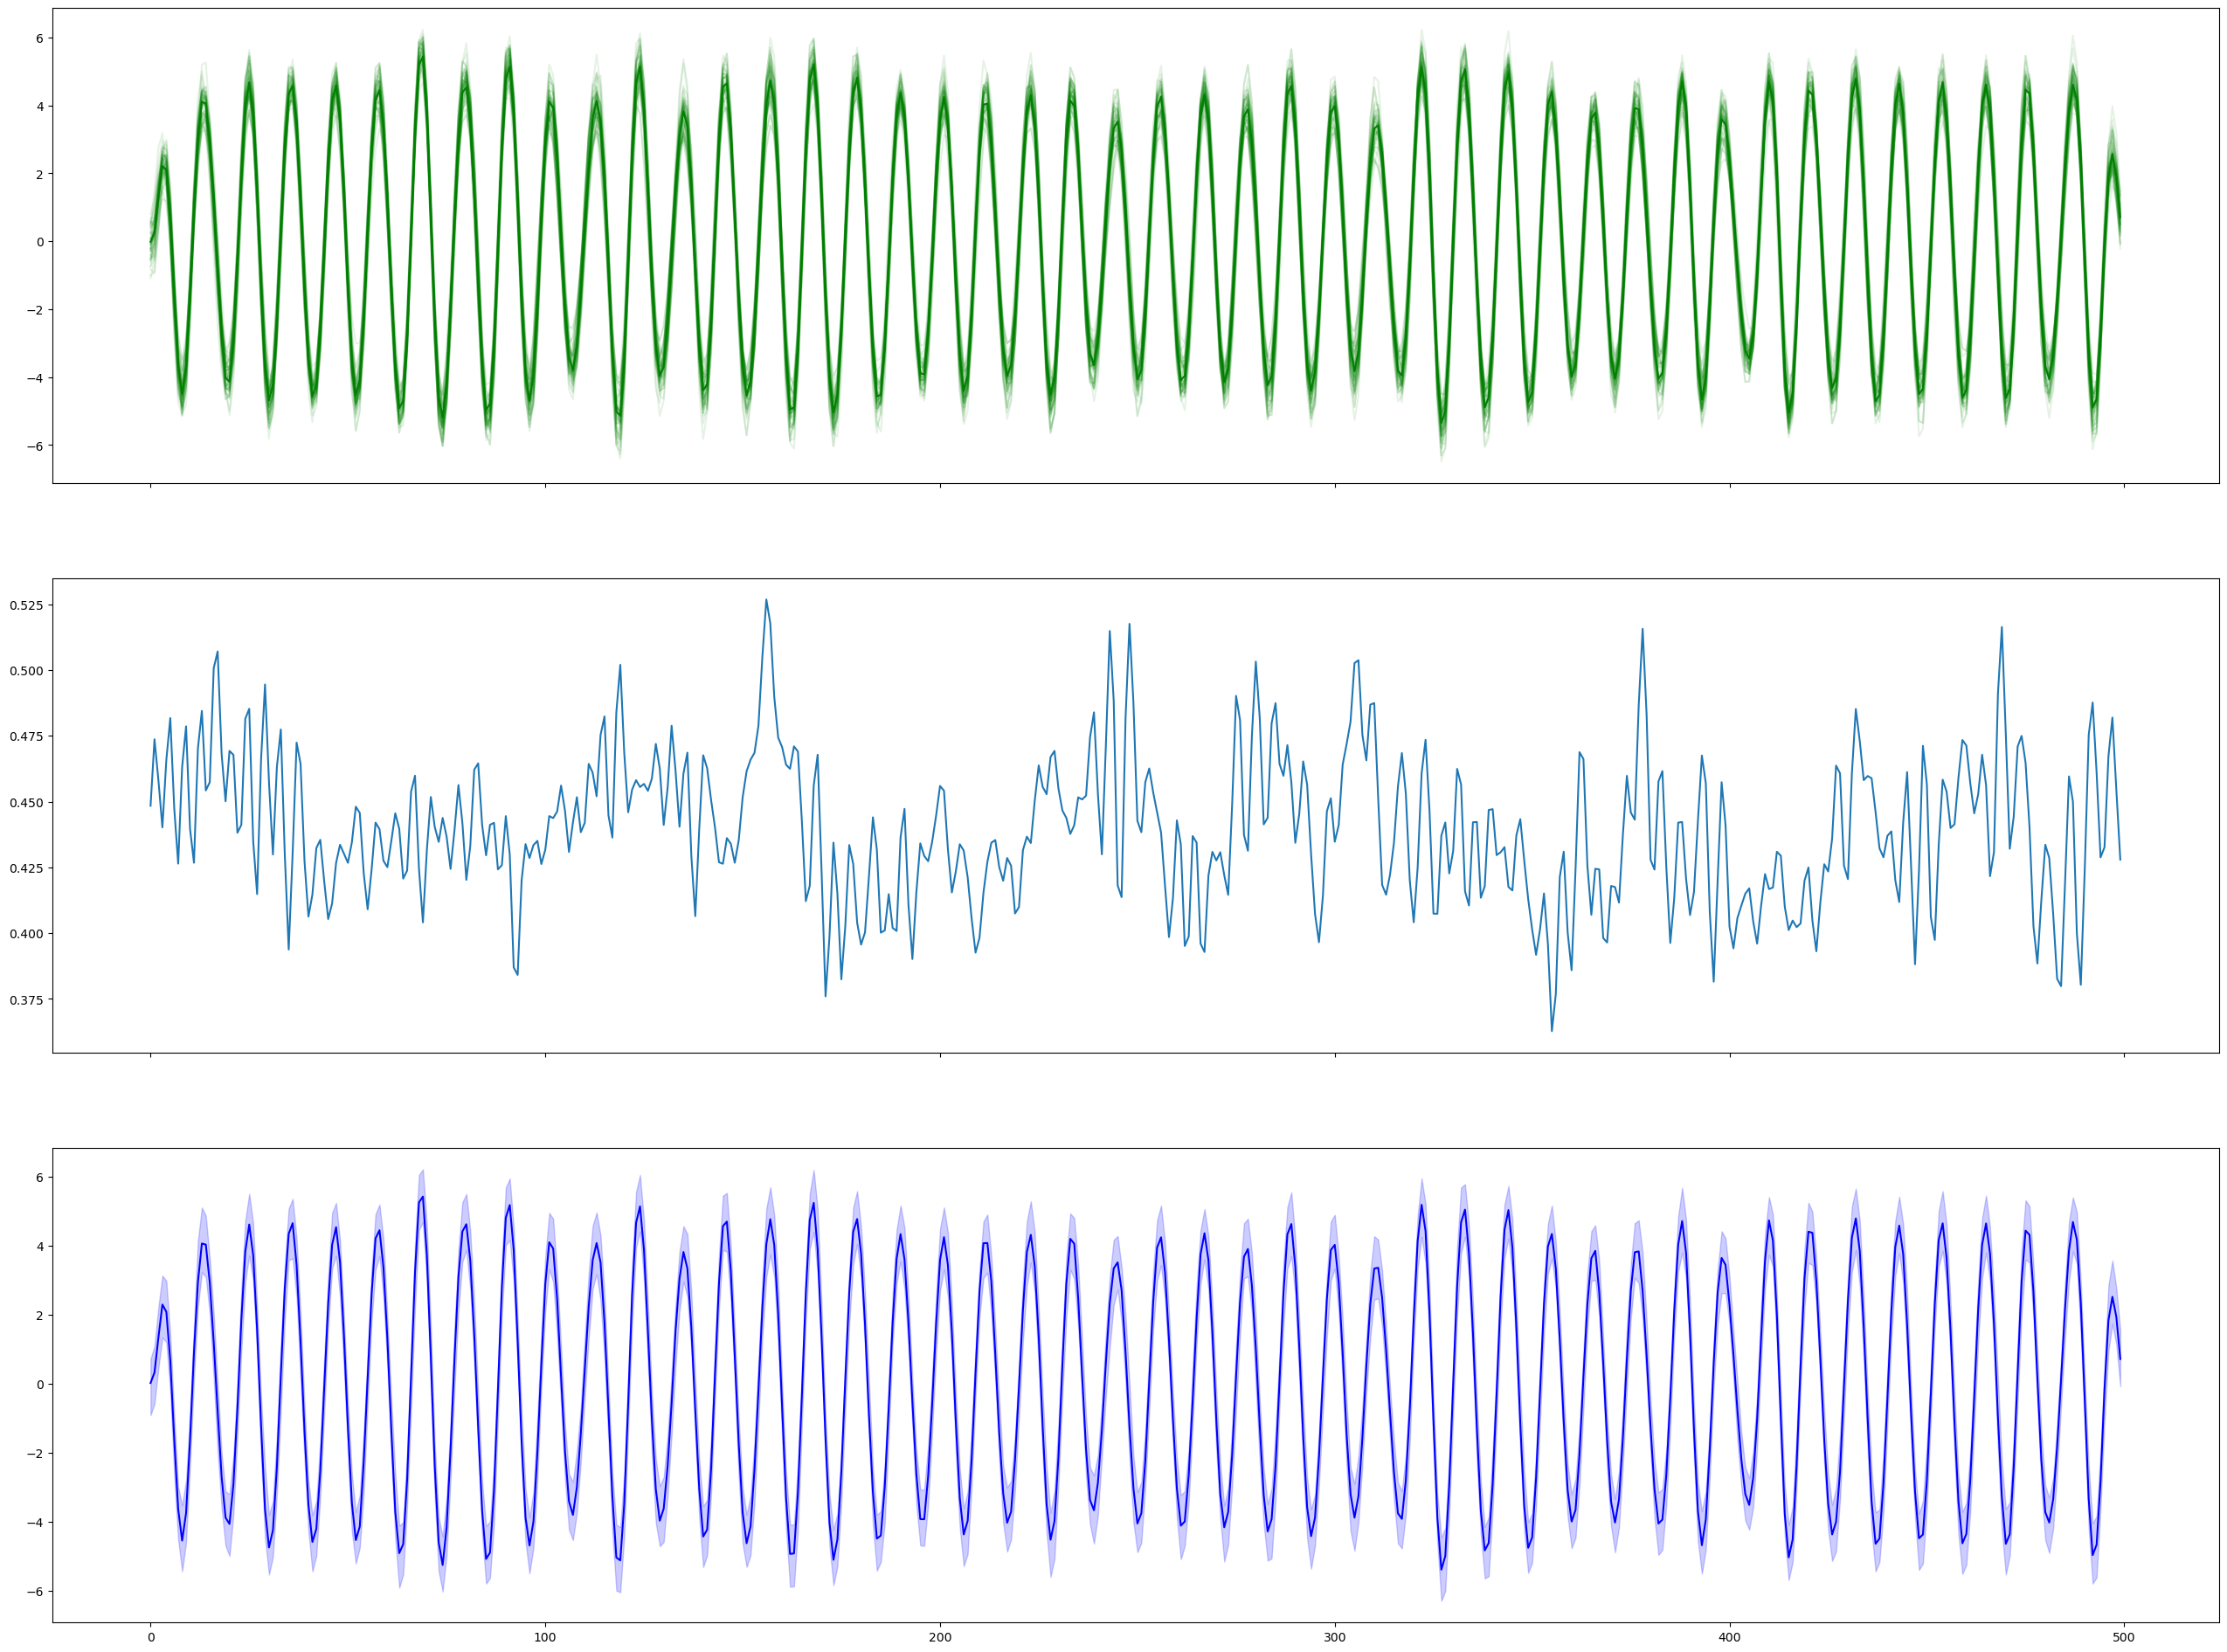

In [6]:

fig, axs = plt.subplots(3, figsize=(32, 24), sharex=True)
for i in np.random.choice(len(new_signal),size=50):
    axs[0].plot(resampler.annual, new_signal[i, :], color="g", alpha=0.1)
    
axs[0].plot(resampler.annual, sig, color="g")
axs[1].plot(resampler.annual, np.std(new_signal, axis=0))
l, m, u = np.percentile(new_signal, (2.5, 50, 97.5 ), axis=0)
axs[2].fill_between(resampler.annual, l, u, color = 'b', alpha=0.2)
axs[2].plot(resampler.annual, m, color = 'b')

In [7]:
axs[0].plot(resampler.annual, sig, color="g")
axs[1].plot(resampler.annual, np.std(new_signal, axis=0))
l, m, u = np.percentile(new_signal, (2.5, 50, 97.5 ), axis=0)
axs[2].fill_between(resampler.annual, l, u, color = 'b', alpha=0.2)
axs[2].plot(resampler.annual, m, color = 'b')

In [8]:
n = y_noise.shape[0]
freq = fftfreq(n, d=1)
l=1./9.677
sz=0.05
mask = resampler.super_gaussian(np.abs(freq) - l, sz, order=30).reshape(1, -1)

/tmp/ipykernel_257432/2437468075.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq,np.abs(fft(y_noise)))
/tmp/ipykernel_257432/2437468075.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq,np.abs(fft(y_noise) * mask).squeeze())
/tmp/ipykernel_257432/2437468075.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq,mask.squeeze()*800)


(-30.0, 30.0)

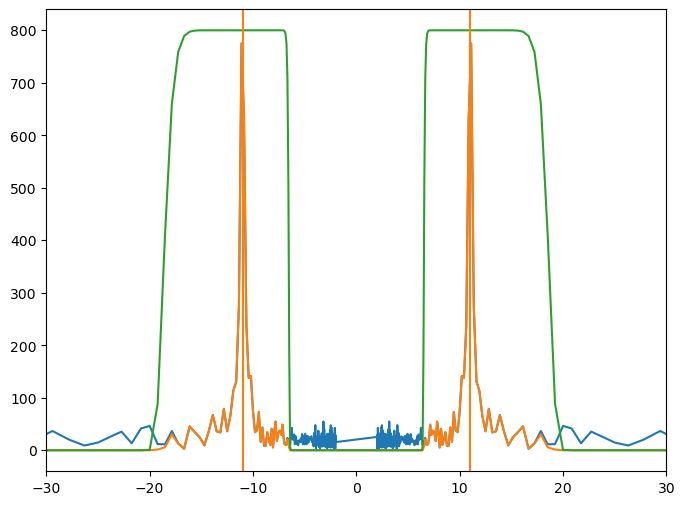

In [9]:
plt.plot(1/freq,np.abs(fft(y_noise)))
plt.plot(1/freq,np.abs(fft(y_noise) * mask).squeeze())
plt.plot(1/freq,mask.squeeze()*800)


plt.axvline(11.,color='C1')
plt.axvline(-11.,color='C1')
plt.xlim(-30,30)

In [10]:
zero_signal=new_signal.copy()
nsamples = new_signal.shape[0]
zero_signal -= new_signal.mean(axis=1)[:,None]
norm_signal=zero_signal/np.sqrt((zero_signal**2).sum(axis=1))[:,None]

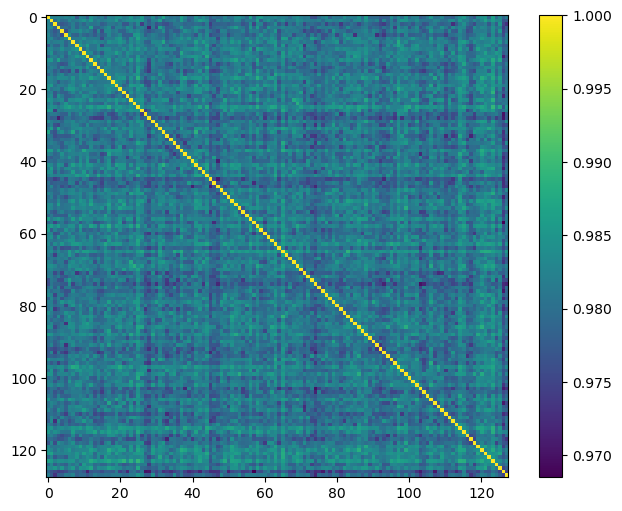

In [11]:
covmat = np.corrcoef(norm_signal)
plt.imshow(covmat[:128,:128])
plt.colorbar()

/root/anaconda3/envs/ticktack/lib/python3.11/site-packages/scipy/signal/_savitzky_golay.py:193: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(np.arange(0, window_stop - window_start),
/root/anaconda3/envs/ticktack/lib/python3.11/site-packages/scipy/signal/_savitzky_golay.py:193: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(np.arange(0, window_stop - window_start),


[0.98275558 0.98229989 0.98276544 ... 0.98090912 0.97773521 0.97473572] [ 0.00144218  0.00096916  0.00141771 ...  0.00052445 -0.00268019
 -0.00571047]


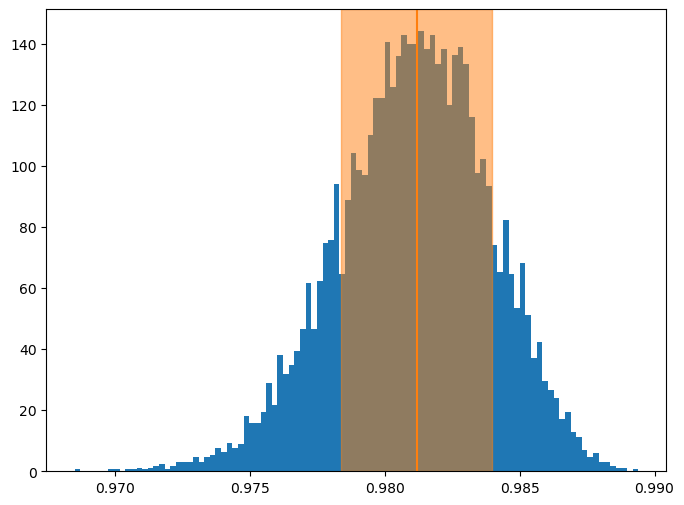

In [23]:
off_diag = covmat[~np.eye(covmat.shape[0],dtype=bool)]
plt.hist(off_diag,bins=100,density=True);
m, s = np.nanmedian(off_diag), np.nanstd(off_diag)
plt.axvline(m,color='C1')
plt.axvspan(m-s,m+s,color='C1',alpha=0.5)

In [27]:
checking=scipy.signal.savgol_filter(norm_signal,128,30)


/root/anaconda3/envs/ticktack/lib/python3.11/site-packages/scipy/signal/_savitzky_golay.py:193: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(np.arange(0, window_stop - window_start),
/root/anaconda3/envs/ticktack/lib/python3.11/site-packages/scipy/signal/_savitzky_golay.py:193: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(np.arange(0, window_stop - window_start),
